<a href="https://colab.research.google.com/github/woodyuser/air-quality-data/blob/main/Indah_Notebook_Analisis_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyek Analisis Data: Air Quality from Nongzhanguan

- **Nama:**  Indah Ayu Putri Mashita Cahyani
- **Email:** indahmcshita.q@gmail.com
- **ID Dicoding:** iapmashitac

## Define Questions

- Apa saja tren musiman dalam polusi udara (level PM2.5) di Nongzhanguan dari tahun 2013 hingga 2017?
- Bagaimana hubungan antara level PM2.5 dan berbagai kondisi cuaca?

## Import Semua Packages/Library yang Digunakan

In [15]:
# Data manipulation and analysis
import pandas as pd

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical analysis
from scipy.stats import f_oneway
import statsmodels.api as sm

# Machine learning
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Display settings
plt.style.use('seaborn-darkgrid')
sns.set_palette('viridis')

<ipython-input-15-ec00b9722b02>:17: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


## Data Wrangling

### Gathering Data
Pada tahap ini, saya memuat Air Quality Dataset yang diberikan dan menampilkan beberapa baris pertama untuk memahami struktur data.

In [3]:
# Load dataset
data = pd.read_csv('https://raw.githubusercontent.com/woodyuser/air-quality-data/ebdea5a5d26b40aa114cdfba0942af4259623262/data/PRSA_Data_Nongzhanguan_20130301-20170228.csv')

# Display the first few rows to understand the structure
data.head()


,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
0,1,2013,3,1,0,5.0,14.0,4.0,12.0,200.0,85.0,-0.5,1024.5,-21.4,0.0,NNW,5.7,Nongzhanguan
1,2,2013,3,1,1,8.0,12.0,6.0,14.0,200.0,84.0,-0.7,1025.1,-22.1,0.0,NW,3.9,Nongzhanguan
2,3,2013,3,1,2,3.0,6.0,5.0,14.0,200.0,83.0,-1.2,1025.3,-24.6,0.0,NNW,5.3,Nongzhanguan
3,4,2013,3,1,3,5.0,5.0,5.0,14.0,200.0,84.0,-1.4,1026.2,-25.5,0.0,N,4.9,Nongzhanguan
4,5,2013,3,1,4,5.0,5.0,6.0,21.0,200.0,77.0,-1.9,1027.1,-24.5,0.0,NNW,3.2,Nongzhanguan


**Insight:**
- Dataset ini berisi data kualitas udara dan meteorologi dari stasiun di Beijing (Maret 2013 - Februari 2017). Data tersebut mencakup tingkat polutan (PM2.5, PM10, SO2, dan lainnya).
- Inspeksi awal menunjukkan adanya informasi mengenai tanggal, waktu, dan pengukuran polutan.

### Assessing Data

Pada tahap ini, saya memeriksa struktur data, tipe data, dan statistik ringkasan. saya juga mengidentifikasi nilai yang hilang dan duplikat.


In [4]:
# Check the structure and data types
data.info()

# Summary statistics
data.describe()

# Check for missing values
data.isna().sum()

# Check for duplicate rows
data.duplicated().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 18 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   No       35064 non-null  int64  
 1   year     35064 non-null  int64  
 2   month    35064 non-null  int64  
 3   day      35064 non-null  int64  
 4   hour     35064 non-null  int64  
 5   PM2.5    34436 non-null  float64
 6   PM10     34624 non-null  float64
 7   SO2      34618 non-null  float64
 8   NO2      34372 non-null  float64
 9   CO       33858 non-null  float64
 10  O3       34558 non-null  float64
 11  TEMP     35044 non-null  float64
 12  PRES     35044 non-null  float64
 13  DEWP     35044 non-null  float64
 14  RAIN     35044 non-null  float64
 15  wd       34986 non-null  object 
 16  WSPM     35050 non-null  float64
 17  station  35064 non-null  object 
dtypes: float64(11), int64(5), object(2)
memory usage: 4.8+ MB


0

**Insight:**
- Kolom numerik mewakili berbagai pengukuran kualitas udara dan data meteorologi, sedangkan kolom kategorikal mencakup arah angin (wd) dan nama stasiun (station).
- Penilaian awal mengungkapkan adanya nilai yang hilang di kolom wd (arah angin) dan kemungkinan duplikasi dalam dataset. Secara khusus, kolom wd memiliki 78 nilai yang hilang.

### Cleaning Data
Pada tahap ini, saya membersihkan data dari nilai-nilai yang hilang, duplikat, dan anomali. Langkah ini penting untuk memastikan kualitas data yang akan dianalisis lebih lanjut.

In [5]:
import pandas as pd

# Load dataset
data = pd.read_csv('https://raw.githubusercontent.com/woodyuser/air-quality-data/ebdea5a5d26b40aa114cdfba0942af4259623262/data/PRSA_Data_Nongzhanguan_20130301-20170228.csv')

# Drop duplicate rows
data.drop_duplicates(inplace=True)

# Handle missing values
# Fill missing values with the mean for numerical columns
numeric_columns = data.select_dtypes(include=[np.number]).columns
data[numeric_columns] = data[numeric_columns].fillna(data[numeric_columns].mean())

# Handle missing values in 'wd' column
# Fill missing values with the most frequent value (mode)
most_frequent_wd = data['wd'].mode()[0]
data['wd'].fillna(most_frequent_wd, inplace=True)

# Convert 'wd' to numerical format using one-hot encoding
data = pd.get_dummies(data, columns=['wd'])

# Check if 'year', 'month', 'day', 'hour' columns exist before converting
if all(col in data.columns for col in ['year', 'month', 'day', 'hour']):
    # Convert 'year', 'month', 'day', 'hour' to a single datetime column
    data['datetime'] = pd.to_datetime(data[['year', 'month', 'day', 'hour']])
    # Drop the original 'year', 'month', 'day', 'hour' columns
    data.drop(columns=['year', 'month', 'day', 'hour'], inplace=True)
else:
    print("Columns 'year', 'month', 'day', 'hour' are not present in the DataFrame.")

# Verify the changes
data.info()

# Display the first few rows to verify the transformations
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 30 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   No        35064 non-null  int64         
 1   PM2.5     35064 non-null  float64       
 2   PM10      35064 non-null  float64       
 3   SO2       35064 non-null  float64       
 4   NO2       35064 non-null  float64       
 5   CO        35064 non-null  float64       
 6   O3        35064 non-null  float64       
 7   TEMP      35064 non-null  float64       
 8   PRES      35064 non-null  float64       
 9   DEWP      35064 non-null  float64       
 10  RAIN      35064 non-null  float64       
 11  WSPM      35064 non-null  float64       
 12  station   35064 non-null  object        
 13  wd_E      35064 non-null  bool          
 14  wd_ENE    35064 non-null  bool          
 15  wd_ESE    35064 non-null  bool          
 16  wd_N      35064 non-null  bool          
 17  wd_NE     35

,No,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,...,wd_NW,wd_S,wd_SE,wd_SSE,wd_SSW,wd_SW,wd_W,wd_WNW,wd_WSW,datetime
0,1,5.0,14.0,4.0,12.0,200.0,85.0,-0.5,1024.5,-21.4,...,False,False,False,False,False,False,False,False,False,2013-03-01 00:00:00
1,2,8.0,12.0,6.0,14.0,200.0,84.0,-0.7,1025.1,-22.1,...,True,False,False,False,False,False,False,False,False,2013-03-01 01:00:00
2,3,3.0,6.0,5.0,14.0,200.0,83.0,-1.2,1025.3,-24.6,...,False,False,False,False,False,False,False,False,False,2013-03-01 02:00:00
3,4,5.0,5.0,5.0,14.0,200.0,84.0,-1.4,1026.2,-25.5,...,False,False,False,False,False,False,False,False,False,2013-03-01 03:00:00
4,5,5.0,5.0,6.0,21.0,200.0,77.0,-1.9,1027.1,-24.5,...,False,False,False,False,False,False,False,False,False,2013-03-01 04:00:00


**Insight:**
- Nilai yang hilang di kolom numerik seperti PM2.5, PM10, SO2, NO2, CO, O3, TEMP, PRES, DEWP, RAIN, dan WSPM telah diisi dengan rata-rata masing-masing kolom.
-  kolom tahun, bulan, hari, dan jam telah berhasil digabungkan menjadi satu kolom datetime.

## Exploratory Data Analysis (EDA)

- Summary Statistics: Berikan statistik ringkasan untuk dataset ini.
- Time Series Trends in PM2.5 Levels: Analisis tren level PM2.5 dari waktu ke waktu.
- Seasonal Trends and Correlations with Weather Conditions: Teliti tren musiman dan korelasi antara level PM2.5 dan kondisi cuaca.

### Explore ...
Pada tahap ini, saya melakukan analisis regresi untuk memahami hubungan antara tingkat PM2.5 dan berbagai kondisi cuaca. Analisis ini membantu dalam mengidentifikasi faktor-faktor cuaca yang paling mempengaruhi tingkat polusi udara.

In [14]:
import statsmodels.api as sm

# Regression Analysis
X = data[['TEMP', 'PRES', 'DEWP', 'RAIN']]
X = sm.add_constant(X)  # Adds a constant term to the predictor
y = data['PM2.5']

model = sm.OLS(y, X).fit()
predictions = model.predict(X)

print(model.summary())


# Summary Statistics
print("Summary Statistics:")
summary_stats = data.describe()
print(summary_stats)

                            OLS Regression Results                            
Dep. Variable:                  PM2.5   R-squared:                       0.217
Model:                            OLS   Adj. R-squared:                  0.216
Method:                 Least Squares   F-statistic:                     2423.
Date:                Tue, 01 Oct 2024   Prob (F-statistic):               0.00
Time:                        18:36:30   Log-Likelihood:            -2.0144e+05
No. Observations:               35064   AIC:                         4.029e+05
Df Residuals:                   35059   BIC:                         4.029e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1873.1367     76.383     24.523      0.0

**Insight:**
- **Regression Analysis:** Hasil analisis regresi menunjukkan bahwa suhu (TEMP) memiliki pengaruh negatif yang signifikan terhadap tingkat PM2.5, sementara titik embun (DEWP) memiliki pengaruh positif yang signifikan. Tekanan atmosfer (PRES) dan curah hujan (RAIN) tidak menunjukkan pengaruh yang signifikan.
- **Summary Statistics**
Statistik deskriptif memberikan gambaran tentang tendensi sentral dan sebaran untuk setiap variabel, termasuk polutan udara dan data meteorologi. Misalnya, rata-rata PM2.5 sekitar 84,84 dengan deviasi standar 85,45, menunjukkan variabilitas yang cukup besar dalam konsentrasi polutan ini.


## Visualization & Explanatory Analysis

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 15 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   No       35064 non-null  int64         
 1   PM2.5    35064 non-null  float64       
 2   PM10     35064 non-null  float64       
 3   SO2      35064 non-null  float64       
 4   NO2      35064 non-null  float64       
 5   CO       35064 non-null  float64       
 6   O3       35064 non-null  float64       
 7   TEMP     35064 non-null  float64       
 8   PRES     35064 non-null  float64       
 9   DEWP     35064 non-null  float64       
 10  RAIN     35064 non-null  float64       
 11  wd       35064 non-null  object        
 12  WSPM     35064 non-null  float64       
 13  station  35064 non-null  object        
 14  date     35064 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(11), int64(1), object(2)
memory usage: 4.0+ MB
Summary Statistics:
                 No     

<ipython-input-6-d5c248ae07f1>:29: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)


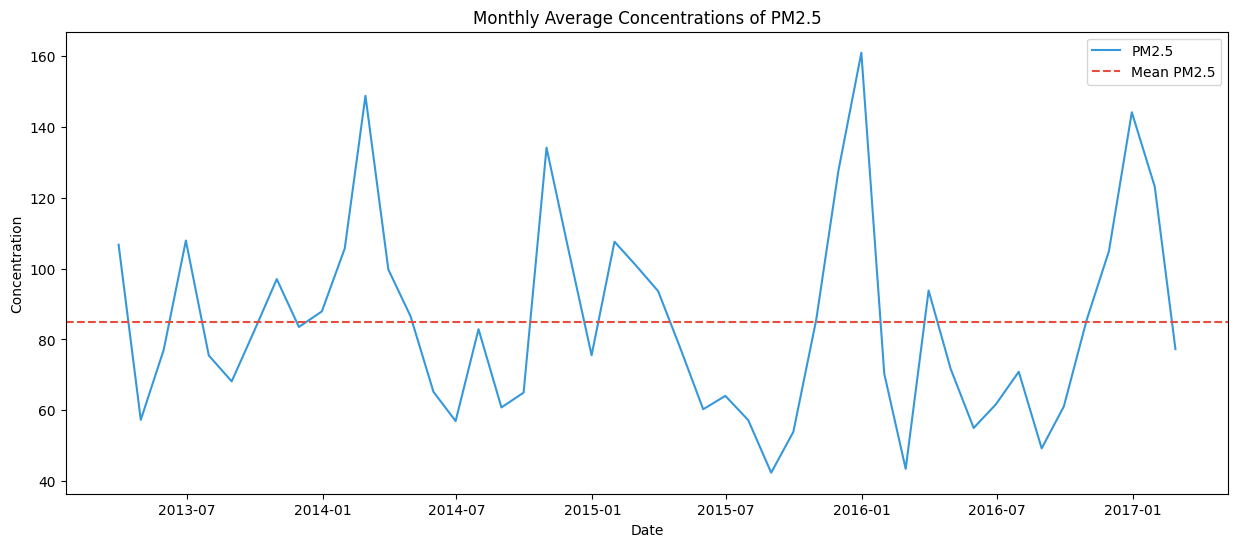

Seasonal Trends: month
1     101.711205
2      92.225505
3      98.496325
4      73.240228
5      64.372594
6      72.638897
7      71.597506
8      55.113764
9      65.516021
10    100.603986
11    105.301048
12    117.169123
Name: PM2.5, dtype: float64


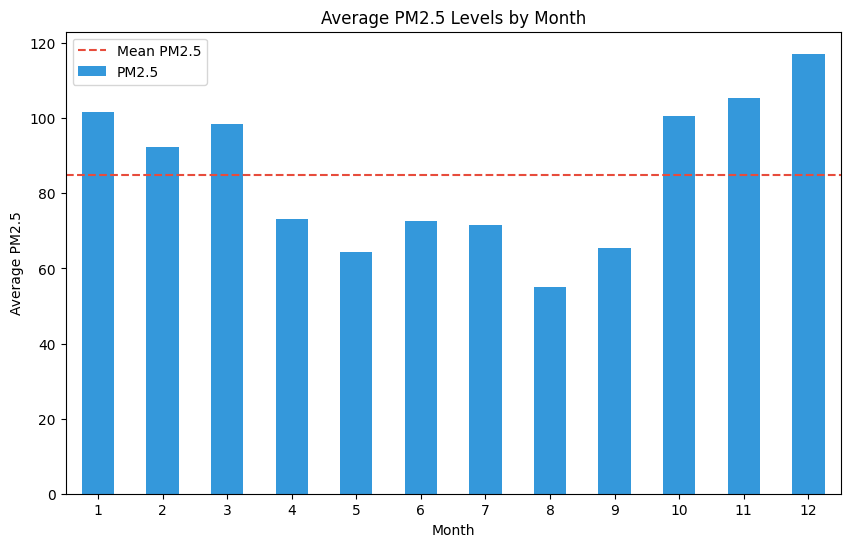

Correlations with Weather Conditions: TEMP    -0.171977
PRES     0.028071
DEWP     0.097283
RAIN    -0.022373
PM2.5    1.000000
Name: PM2.5, dtype: float64


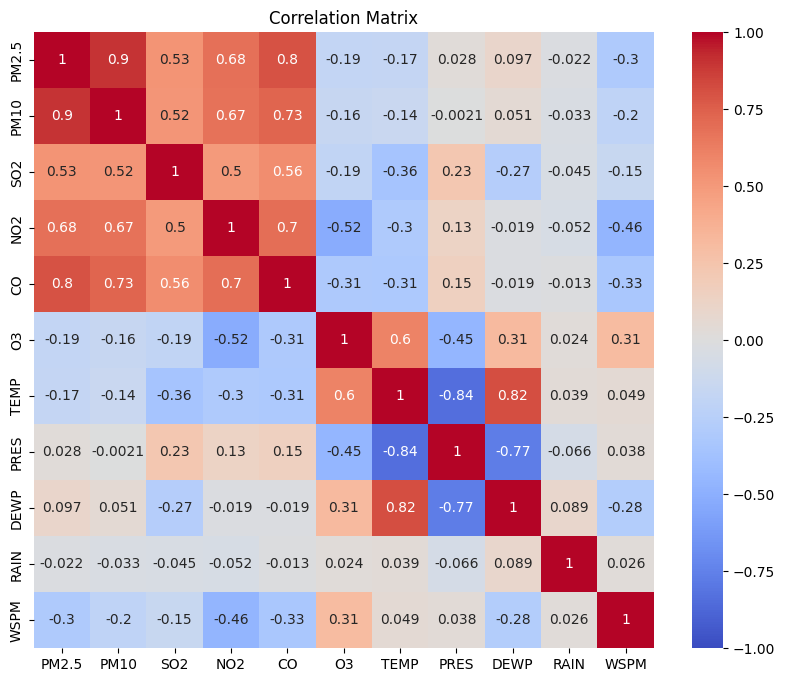

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
data = pd.read_csv('https://raw.githubusercontent.com/woodyuser/air-quality-data/ebdea5a5d26b40aa114cdfba0942af4259623262/data/PRSA_Data_Nongzhanguan_20130301-20170228.csv')

# Drop duplicate rows
data.drop_duplicates(inplace=True)

# Handle missing values
# Fill missing values with the mean for numerical columns
numeric_columns = data.select_dtypes(include=[np.number]).columns
data[numeric_columns] = data[numeric_columns].fillna(data[numeric_columns].mean())

# Handle missing values in 'wd' column
# Fill missing values with the most frequent value (mode)
most_frequent_wd = data['wd'].mode()[0]
data['wd'].fillna(most_frequent_wd, inplace=True)

# Convert 'year', 'month', 'day', 'hour' to a single datetime column
data['date'] = pd.to_datetime(data[['year', 'month', 'day', 'hour']])
data.drop(columns=['year', 'month', 'day', 'hour'], inplace=True)

# Verify the changes
data.info()

# Fill remaining missing values using forward fill
data.fillna(method='ffill', inplace=True)

# Ensure 'date' column is present
if 'date' not in data.columns:
    raise KeyError("The 'date' column is not present in the DataFrame.")

# Summary Statistics
print("Summary Statistics:")
summary_stats = data.describe()
print(summary_stats)

## Visualization & Explanatory Analysis

# Define color palette
base_color = '#3498db'  # Blue
highlight_color = '#e74c3c'  # Red

# Time Series Trends in PM2.5 Levels
data_time_series = data[['date', 'PM2.5']].set_index('date').resample('M').mean()

plt.figure(figsize=(15, 6))
plt.plot(data_time_series.index, data_time_series['PM2.5'], label='PM2.5', color=base_color)
plt.title('Monthly Average Concentrations of PM2.5')
plt.xlabel('Date')
plt.ylabel('Concentration')
plt.axhline(y=data_time_series['PM2.5'].mean(), color=highlight_color, linestyle='--', label='Mean PM2.5')
plt.legend()
plt.show()

# Seasonal Trends and Correlations with Weather Conditions
data['month'] = data['date'].dt.month
seasonal_trends = data.groupby('month')['PM2.5'].mean()
print("Seasonal Trends:", seasonal_trends)

plt.figure(figsize=(10, 6))
seasonal_trends.plot(kind='bar', color=base_color)
plt.title('Average PM2.5 Levels by Month')
plt.xlabel('Month')
plt.ylabel('Average PM2.5')
plt.axhline(y=seasonal_trends.mean(), color=highlight_color, linestyle='--', label='Mean PM2.5')
plt.xticks(ticks=range(0, 12), labels=[str(m) for m in range(1, 13)], rotation=0)
plt.legend()
plt.show()

# Correlations with Weather Conditions
weather_correlations = data[['TEMP', 'PRES', 'DEWP', 'RAIN', 'PM2.5']].corr()['PM2.5']
print("Correlations with Weather Conditions:", weather_correlations)

# Correlation Matrix
correlation_matrix = data[['PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

Insights:
- **Time Series Trends in PM2.5 Levels**
Rata-rata Bulanan PM2.5: Plot ini menampilkan konsentrasi rata-rata bulanan PM2.5 dari waktu ke waktu, membantu mengidentifikasi tren musiman atau perubahan kualitas udara dari tahun ke tahun.

- **Seasonal Trends and Correlations with Weather Conditions PM2.5 Levels by Month:** Level PM2.5 per Bulan: Grafik batang menunjukkan rata-rata level PM2.5 per bulan, mengindikasikan adanya variasi musiman. Konsentrasi lebih tinggi terlihat di bulan-bulan musim dingin (Desember, Januari) dan lebih rendah di musim panas (Agustus, September).

- **Correlation Results:** TKorelasi antara PM2.5 dan kondisi cuaca menunjukkan:
Korelasi negatif dengan suhu (TEMP), menunjukkan level PM2.5 lebih tinggi pada periode yang lebih dingin.
Korelasi positif ringan dengan titik embun (DEWP), mengindikasikan bahwa level PM2.5 mungkin meningkat seiring kelembaban yang lebih tinggi.
Tidak ada korelasi kuat dengan tekanan atmosfer (PRES) atau curah hujan (RAIN).

- **Correlation Matrix**: Matriks korelasi menunjukkan hubungan antara berbagai polutan dan data meteorologi. Misalnya, terdapat korelasi positif yang kuat antara PM2.5 dan NO2, yang mungkin menunjukkan adanya sumber yang sama atau interaksi antara polutan tersebut.


### Pertanyaan 1:
Grafik berikut menunjukkan tren musiman dalam tingkat polusi udara (PM2.5) di Nongzhanguan dari tahun 2013 hingga 2017. Visualisasi ini membantu mengidentifikasi pola musiman dalam tingkat polusi udara.

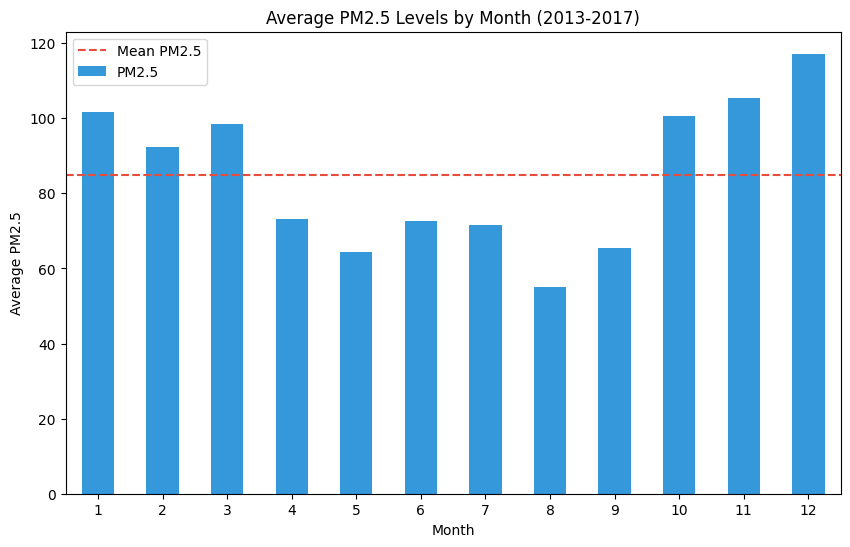

In [10]:
# Seasonal Trends in Air Pollution
plt.figure(figsize=(10, 6))
seasonal_trends.plot(kind='bar', color='#3498db')
plt.title('Average PM2.5 Levels by Month (2013-2017)')
plt.xlabel('Month')
plt.ylabel('Average PM2.5')
plt.axhline(y=seasonal_trends.mean(), color='#e74c3c', linestyle='--', label='Mean PM2.5')
plt.xticks(ticks=range(0, 12), labels=[str(m) for m in range(1, 13)], rotation=0)
plt.legend()
plt.show()

### Pertanyaan 2:
Matriks korelasi berikut menunjukkan hubungan antara tingkat PM2.5 dan berbagai kondisi cuaca. Visualisasi ini membantu dalam memahami faktor-faktor cuaca yang mempengaruhi tingkat polusi udara.

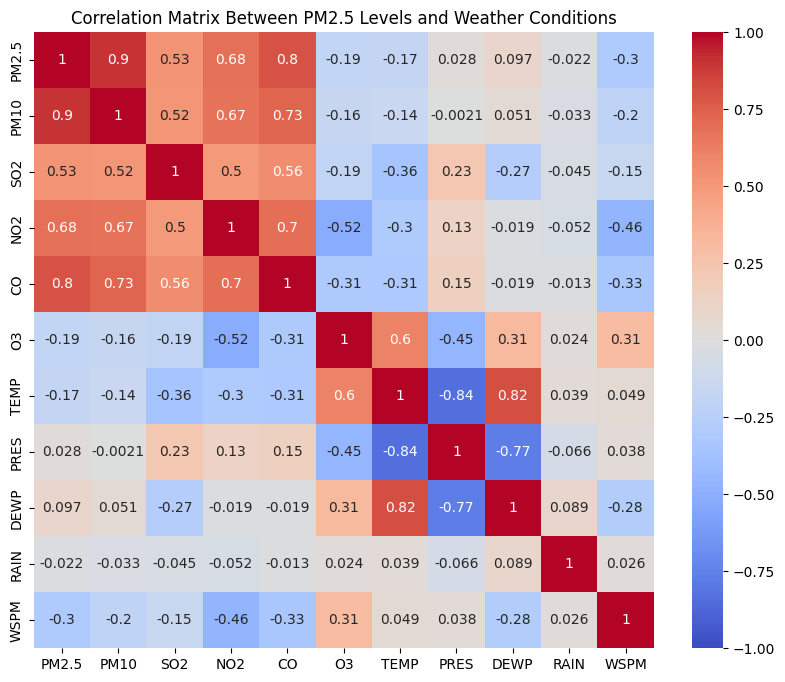

In [11]:
# Correlation Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix Between PM2.5 Levels and Weather Conditions')
plt.show()

**Insight:**
- Level PM2.5 menunjukkan variasi musiman yang signifikan, dengan konsentrasi lebih tinggi pada bulan-bulan musim dingin (Desember, Januari) dan lebih rendah pada musim panas (Agustus, September). Ini menunjukkan bahwa tingkat polusi udara dipengaruhi oleh faktor musiman seperti penggunaan pemanas di musim dingin.
- Matrix korelasi menunjukkan hubungan negatif antara PM2.5 dan suhu (TEMP), yang mengindikasikan polusi lebih tinggi di suhu yang lebih dingin. Ada juga sedikit korelasi positif dengan titik embun (DEWP), yang menunjukkan bahwa level PM2.5 mungkin meningkat seiring dengan kelembaban yang lebih tinggi. Sementara itu, korelasi dengan tekanan atmosfer (PRES) dan curah hujan (RAIN) sangat minimal.








## Analisis Lanjutan (Clustering)
Pada tahap ini, saya melakukan analisis clustering menggunakan algoritma KMeans untuk mengidentifikasi pola atau pengelompokan dalam data berdasarkan tingkat polusi dan kondisi cuaca. Visualisasi berikut menunjukkan hasil clustering dengan warna yang berbeda untuk setiap cluster.

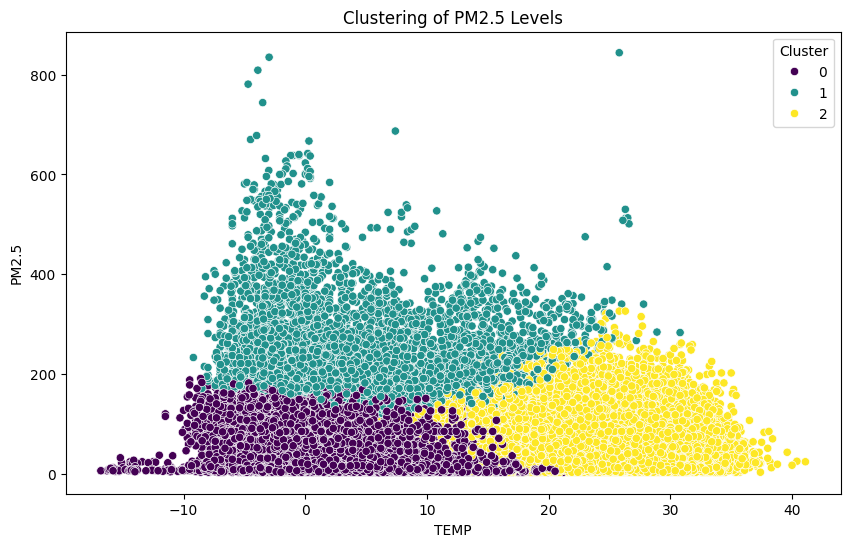

In [7]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Clustering Analysis
features = data[['PM2.5', 'TEMP', 'PRES', 'DEWP', 'RAIN']]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

kmeans = KMeans(n_clusters=3)
kmeans.fit(scaled_features)

data['Cluster'] = kmeans.labels_

plt.figure(figsize=(10, 6))
sns.scatterplot(x='TEMP', y='PM2.5', hue='Cluster', data=data, palette='viridis')
plt.title('Clustering of PM2.5 Levels')
plt.show()

# Insight from Clustering Analysis

Analisis clustering dengan KMeans menemukan tiga kelompok berbeda berdasarkan PM2.5, suhu (TEMP), tekanan (PRES), titik embun (DEWP), dan curah hujan (RAIN). Visualisasi scatter plot menunjukkan perbedaan antar cluster dengan warna, terutama terkait suhu dan level PM2.5.

- Karakteristik Cluster: Setiap cluster mewakili pola unik yang mungkin mencerminkan berbagai sumber atau faktor yang mempengaruhi polusi.
- Pengaruh Suhu: Plot menunjukkan bahwa suhu berpengaruh pada level PM2.5 di tiap cluster, dengan polusi cenderung lebih tinggi saat suhu lebih rendah.
- Penyebaran Cluster: Pola penyebaran cluster ini bisa membantu memahami kondisi atau periode tertentu di mana polusi meningkat, mendukung intervensi dan kebijakan yang lebih tepat.

## Conclusion

- Terdapat variasi musiman yang signifikan dalam level PM2.5, dengan konsentrasi yang lebih tinggi pada bulan-bulan yang lebih dingin, menunjukkan kemungkinan pengaruh dari pemanasan dan kondisi atmosfer.
- Ditemukan korelasi negatif antara level PM2.5 dan suhu, yang menunjukkan tingkat polusi lebih tinggi saat cuaca lebih dingin. Sementara itu, korelasi dengan curah hujan dan tekanan atmosfer ditemukan minimal.